# Imports

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Algoritmo

In [4]:
def RFR(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }

    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        RandomForestRegressor(
            n_estimators=80,
            max_features='log2', # Usar raiz quadrada do número de características
            max_depth=20,    # Profundidade das árvores
            # min_samples_split=5,  # Número mínimo de amostras necessárias para dividir um nó
            # min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
            bootstrap=True,    # Usar amostragem bootstrap
            oob_score=False,   # Não usar amostragem fora da bolsa
            random_state=1     # Semente aleatória
        )
    )

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df


# Ajusta saída

In [5]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])


def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


# MSC - RFR

=== Training Metrics ===
R²: 0.9533
Correlation coefficient: 0.9798
RMSE: 0.5451
MAE: 0.4302
Relative absolute error: 20.7576
Root relative squared error: 21.6066
Slope: 1.0909
Offset: -1.2866
=== Cross-Validation Metrics ===
R²: 0.6783
Correlation coefficient: 0.8241
RMSE: 1.4309
MAE: 1.1301
Relative absolute error: 54.5295
Root relative squared error: 56.7178
Slope: 1.0330
Offset: -0.4910
=== Validation Metrics ===
R²: 0.6984
Correlation coefficient: 0.8404
RMSE: 1.3497
MAE: 1.0965
Relative absolute error: 53.5426
Root relative squared error: 54.9211
Slope: 1.0576
Offset: -1.0006


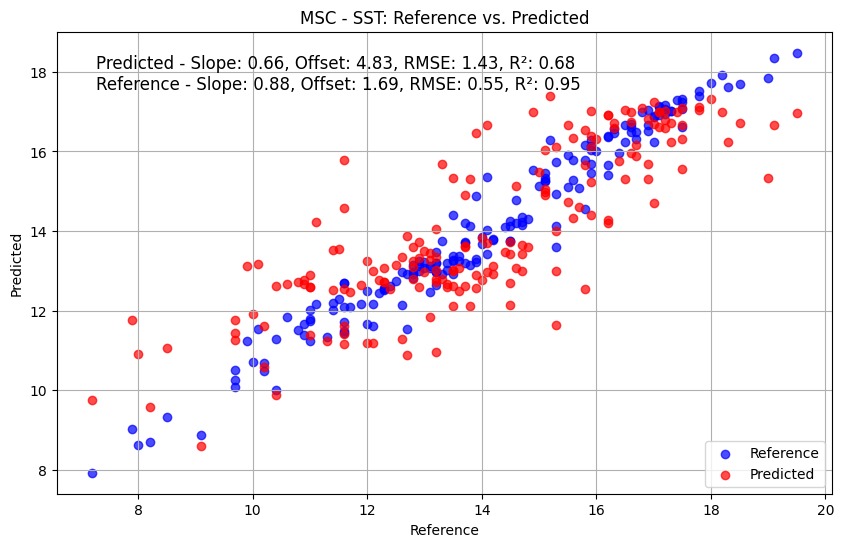

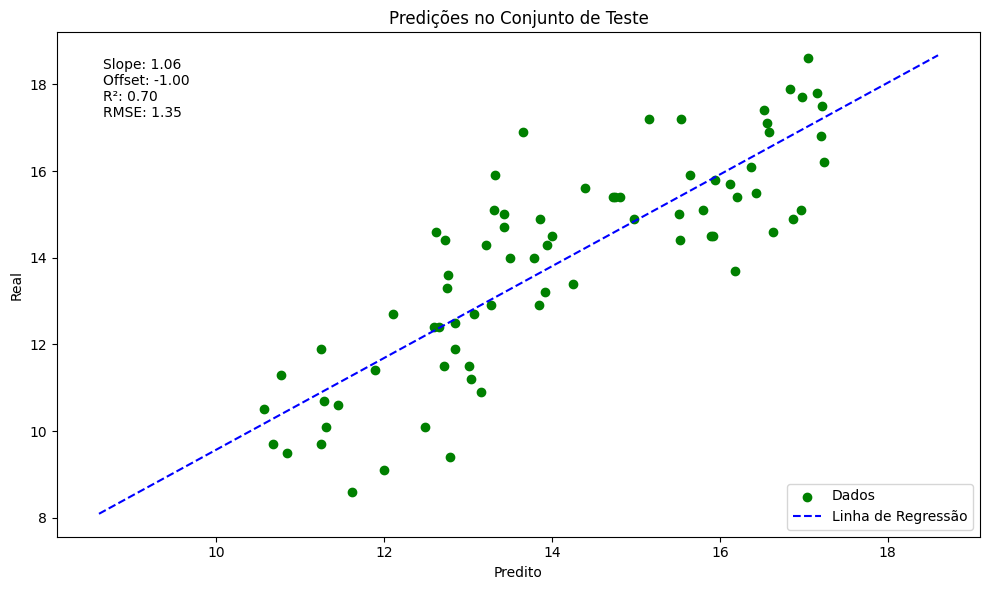

C:\Users\Luyza\AppData\Local\Temp\ipykernel_9400\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [6]:
results_msc_sst = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['SST'].values, df_msc_val.iloc[:, 6:], df_msc_val['SST'].values, 'MSC', 'SST')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'SST')

=== Training Metrics ===
R²: 0.9290
Correlation coefficient: 0.9707
RMSE: 0.1512
MAE: 0.0955
Relative absolute error: 22.1132
Root relative squared error: 26.6485
Slope: 1.1276
Offset: -0.1647
=== Cross-Validation Metrics ===
R²: 0.3896
Correlation coefficient: 0.6339
RMSE: 0.4433
MAE: 0.2642
Relative absolute error: 61.2040
Root relative squared error: 78.1296
Slope: 0.8723
Offset: 0.1127
=== Validation Metrics ===
R²: 0.6178
Correlation coefficient: 0.8081
RMSE: 0.3048
MAE: 0.2022
Relative absolute error: 50.3813
Root relative squared error: 61.8239
Slope: 0.8532
Offset: 0.1102


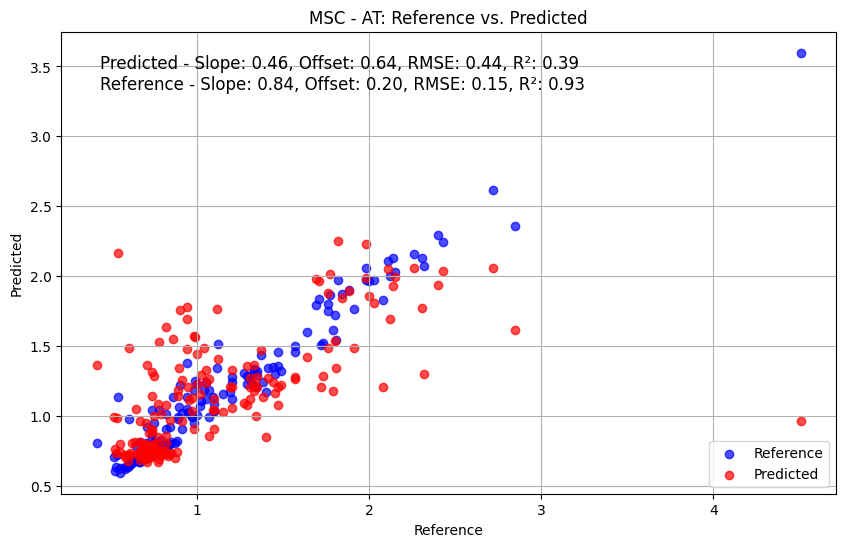

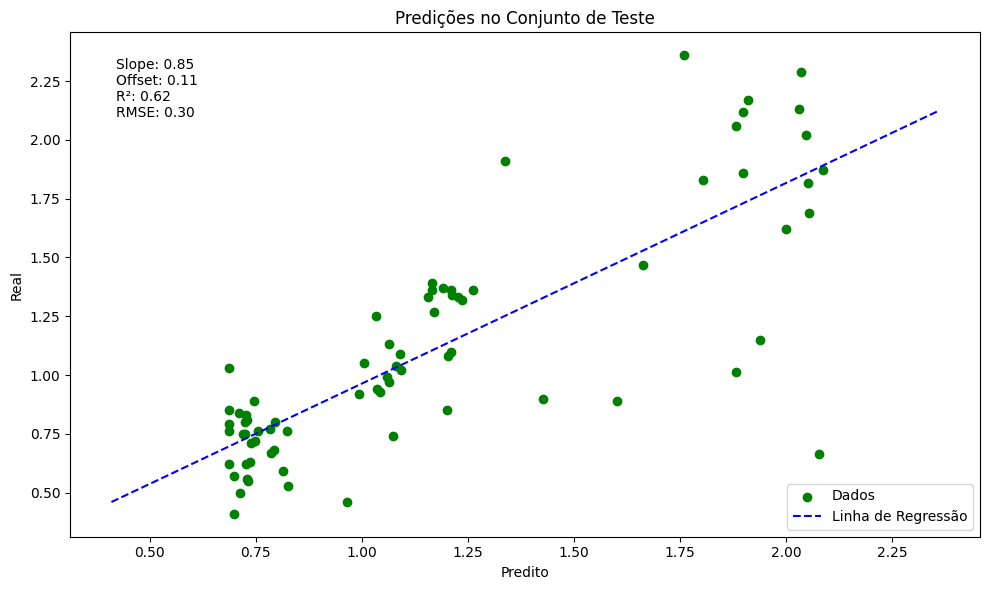

In [7]:
results_msc_at = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['AT'].values, df_msc_val.iloc[:, 6:], df_msc_val['AT'].values, 'MSC', 'AT')
infos_msc = add_plot_infos(infos_msc, results_msc_at, 'AT')

=== Training Metrics ===
R²: 0.9032
Correlation coefficient: 0.9710
RMSE: 0.0950
MAE: 0.0612
Relative absolute error: 25.4258
Root relative squared error: 31.1150
Slope: 1.2581
Offset: -0.8504
=== Cross-Validation Metrics ===
R²: 0.3143
Correlation coefficient: 0.5621
RMSE: 0.2528
MAE: 0.1640
Relative absolute error: 68.1820
Root relative squared error: 82.8086
Slope: 0.9586
Offset: 0.1261
=== Validation Metrics ===
R²: 0.6116
Correlation coefficient: 0.7989
RMSE: 0.1693
MAE: 0.0962
Relative absolute error: 41.0889
Root relative squared error: 62.3196
Slope: 1.1222
Offset: -0.3587


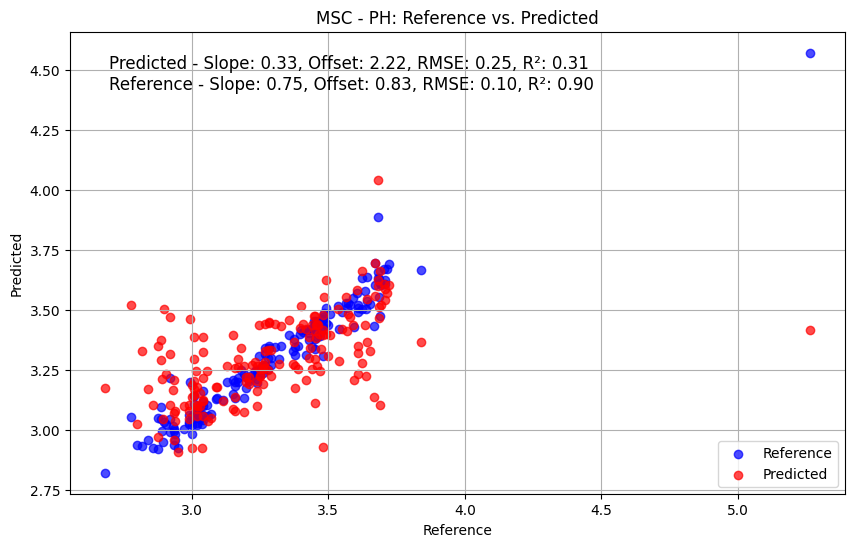

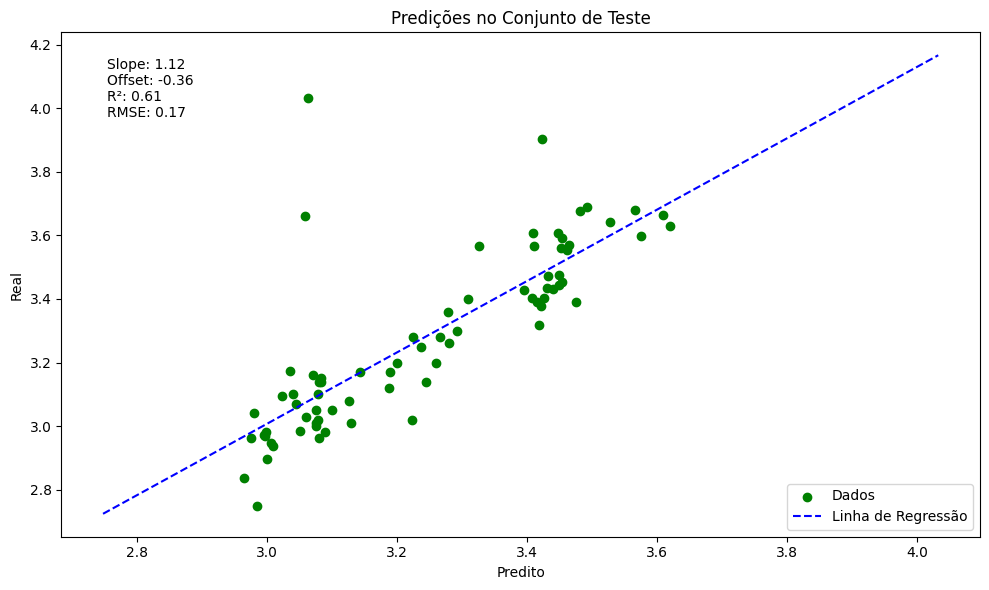

In [8]:
results_msc_ph = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['PH'].values, df_msc_val.iloc[:, 6:], df_msc_val['PH'].values, 'MSC', 'PH')
infos_msc = add_plot_infos(infos_msc, results_msc_ph, 'PH')

=== Training Metrics ===
R²: 0.9149
Correlation coefficient: 0.9682
RMSE: 27.8528
MAE: 21.8725
Relative absolute error: 29.1468
Root relative squared error: 29.1758
Slope: 1.1832
Offset: -93.8415
=== Cross-Validation Metrics ===
R²: 0.3826
Correlation coefficient: 0.6227
RMSE: 75.0144
MAE: 59.3140
Relative absolute error: 79.0402
Root relative squared error: 78.5777
Slope: 0.8964
Offset: 53.6416
=== Validation Metrics ===
R²: 0.5279
Correlation coefficient: 0.7407
RMSE: 66.4305
MAE: 55.8576
Relative absolute error: 67.8294
Root relative squared error: 68.7069
Slope: 1.0955
Offset: -61.5386


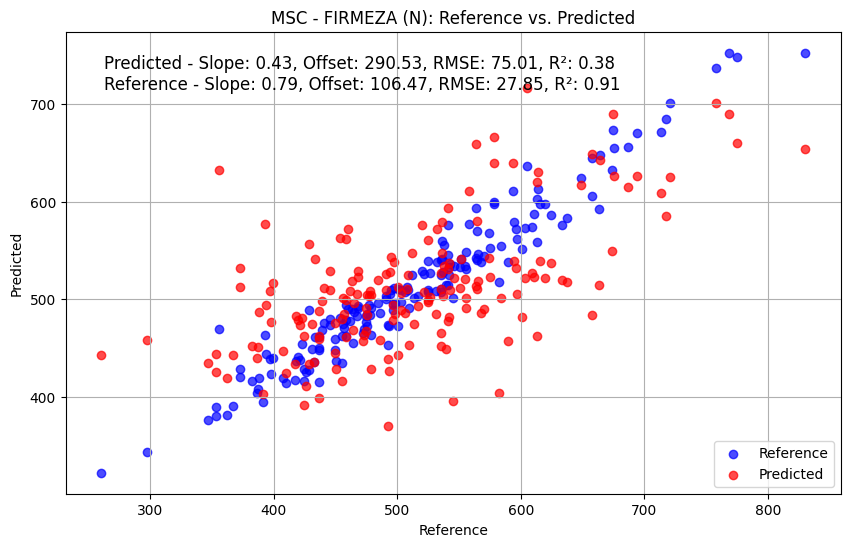

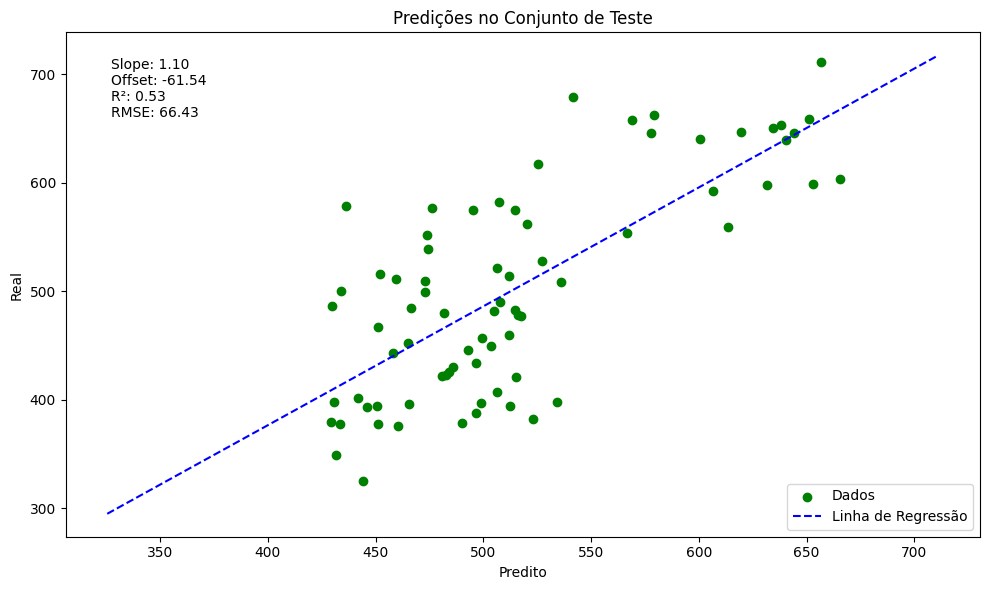

In [9]:
results_msc_firmeza = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['FIRMEZA (N)'].values, df_msc_val.iloc[:, 6:], df_msc_val['FIRMEZA (N)'].values, 'MSC', 'FIRMEZA (N)')
infos_msc = add_plot_infos(infos_msc, results_msc_firmeza, 'FIRMEZA (N)')


=== Training Metrics ===
R²: 0.9346
Correlation coefficient: 0.9719
RMSE: 0.7934
MAE: 0.4895
Relative absolute error: 21.0607
Root relative squared error: 25.5644
Slope: 1.1141
Offset: -1.7630
=== Cross-Validation Metrics ===
R²: 0.5596
Correlation coefficient: 0.7486
RMSE: 2.0594
MAE: 1.2630
Relative absolute error: 54.3368
Root relative squared error: 66.3595
Slope: 0.9643
Offset: 0.5707
=== Validation Metrics ===
R²: 0.8164
Correlation coefficient: 0.9044
RMSE: 1.0810
MAE: 0.8270
Relative absolute error: 38.6392
Root relative squared error: 42.8433
Slope: 1.0366
Offset: -0.6108


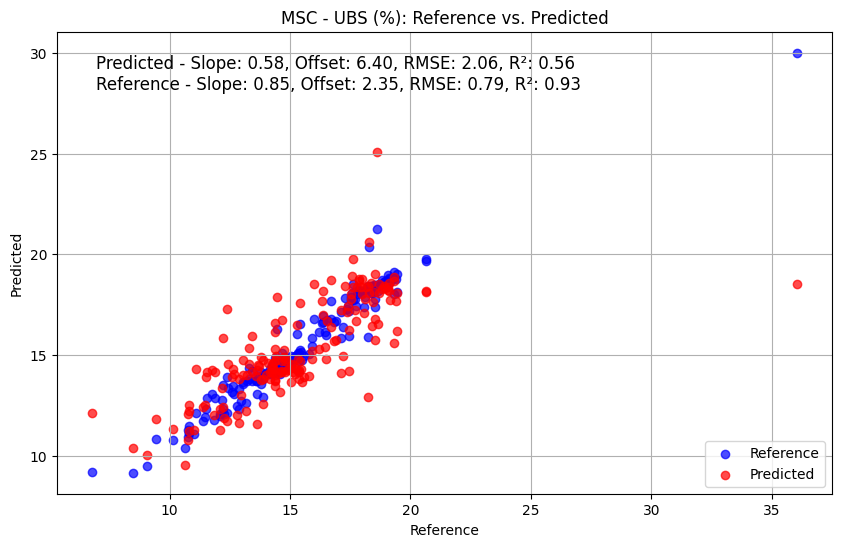

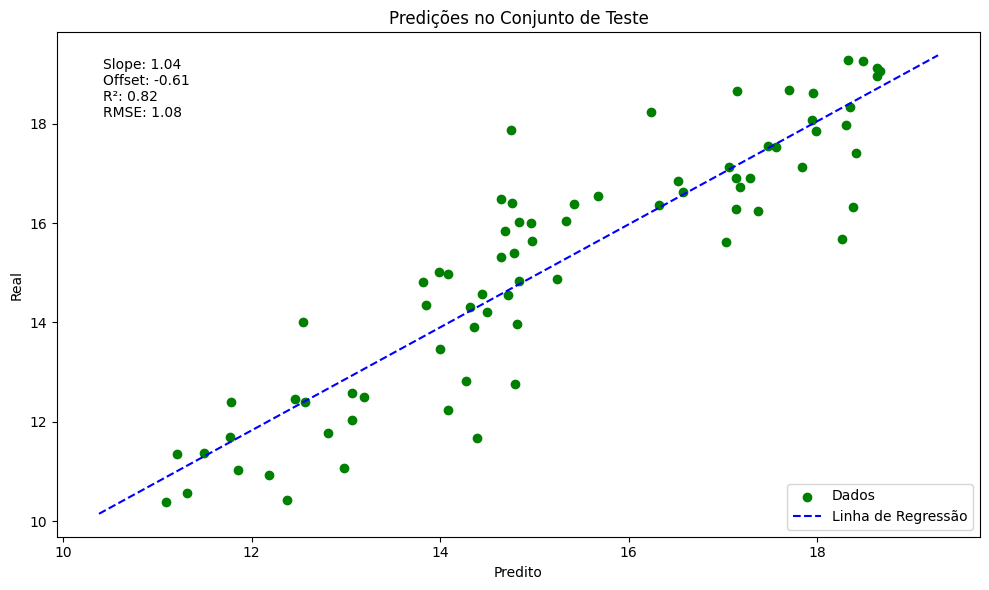

In [10]:
results_msc_ubs = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['UBS (%)'].values, df_msc_val.iloc[:, 6:], df_msc_val['UBS (%)'].values, 'MSC', 'UBS (%)')
infos_msc = add_plot_infos(infos_msc, results_msc_ubs, 'UBS (%)')

In [11]:
infos_msc.to_excel('plot_infos_RFR_msc.xlsx', index=False)
infos_msc

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.953316,0.979796,0.545087,0.430193,20.757624,21.606579,1.090858,-1.286555
1,SST,Cross-Validation,0.678309,0.824089,1.430867,1.130100,54.529475,56.717787,1.032995,-0.491001
2,SST,Validation,0.698367,0.840402,1.349701,1.096533,53.542596,54.921094,1.057569,-1.000626
3,AT,Training,0.928986,0.970698,0.151192,0.095454,22.113188,26.648538,1.127564,-0.164721
4,AT,Cross-Validation,0.389576,0.633929,0.443272,0.264192,61.203958,78.129635,0.872261,0.112694
5,AT,Validation,0.617781,0.808051,0.304788,0.202208,50.381327,61.823853,0.853234,0.110197
6,PH,Training,0.903186,0.971022,0.095004,0.061157,25.425845,31.114999,1.258108,-0.850423
7,PH,Cross-Validation,0.314273,0.562140,0.252842,0.163998,68.181972,82.808641,0.958647,0.126149
8,PH,Validation,0.611627,0.798870,0.169337,0.096184,41.088941,62.319609,1.122192,-0.358703
9,FIRMEZA (N),Training,0.914877,0.968171,27.852758,21.872539,29.146753,29.175843,1.183225,-93.841506


# SNV - RFR

=== Training Metrics ===
R²: 0.9598
Correlation coefficient: 0.9828
RMSE: 0.5116
MAE: 0.4167
Relative absolute error: 20.1222
Root relative squared error: 20.0591
Slope: 1.0862
Offset: -1.2297
=== Cross-Validation Metrics ===
R²: 0.7042
Correlation coefficient: 0.8393
RMSE: 1.3871
MAE: 1.1253
Relative absolute error: 54.3431
Root relative squared error: 54.3893
Slope: 1.0190
Offset: -0.2617
=== Validation Metrics ===
R²: 0.7236
Correlation coefficient: 0.8519
RMSE: 1.2554
MAE: 0.9931
Relative absolute error: 48.5755
Root relative squared error: 52.5702
Slope: 1.0121
Offset: -0.2754


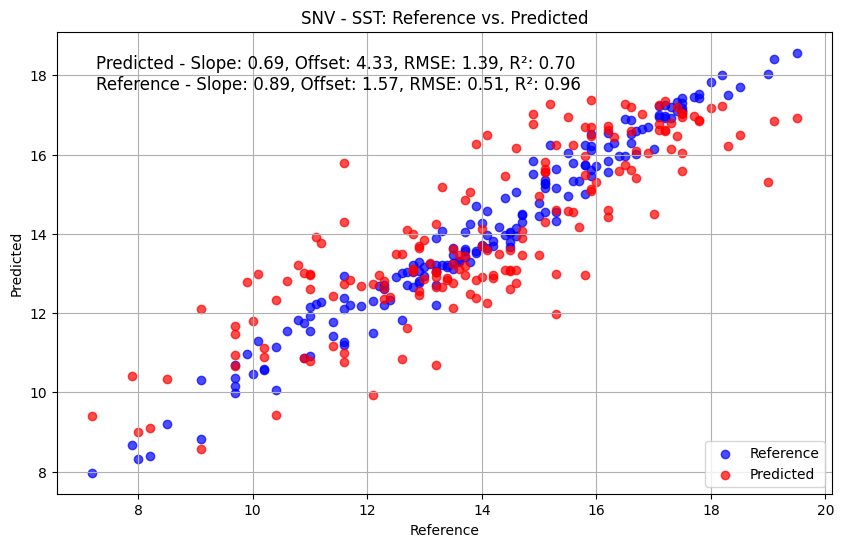

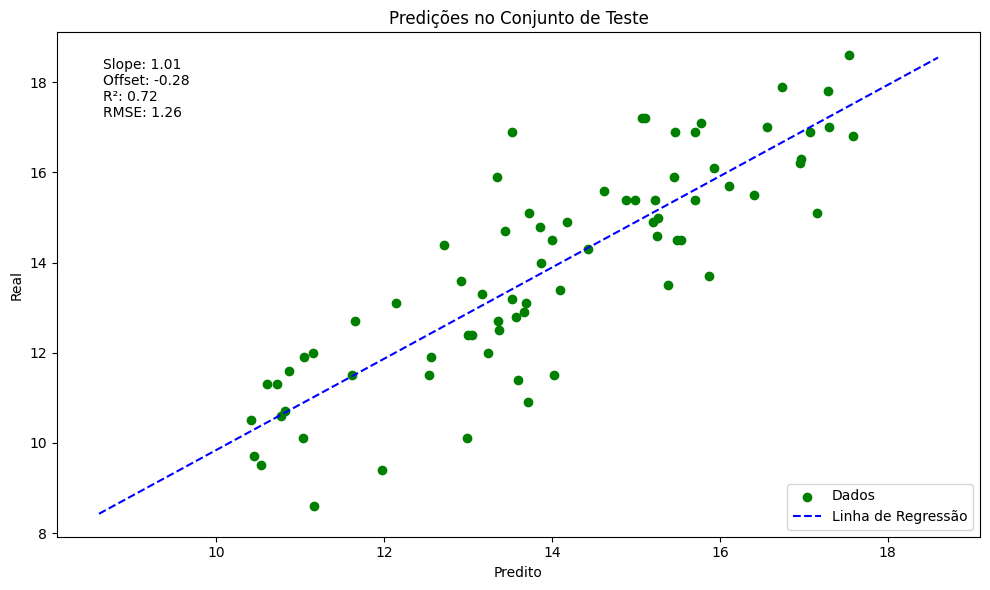

C:\Users\Luyza\AppData\Local\Temp\ipykernel_9400\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [12]:
results_snv_sst = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['SST'].values, df_snv_val.iloc[:, 6:], df_snv_val['SST'].values, 'SNV', 'SST')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'SST')

=== Training Metrics ===
R²: 0.9309
Correlation coefficient: 0.9746
RMSE: 0.1490
MAE: 0.0900
Relative absolute error: 21.4963
Root relative squared error: 26.2904
Slope: 1.1634
Offset: -0.1911
=== Cross-Validation Metrics ===
R²: 0.3910
Correlation coefficient: 0.6297
RMSE: 0.4422
MAE: 0.2512
Relative absolute error: 59.9684
Root relative squared error: 78.0354
Slope: 0.9042
Offset: 0.0897
=== Validation Metrics ===
R²: 0.6465
Correlation coefficient: 0.8182
RMSE: 0.2936
MAE: 0.1923
Relative absolute error: 45.0473
Root relative squared error: 59.4552
Slope: 0.8474
Offset: 0.1594


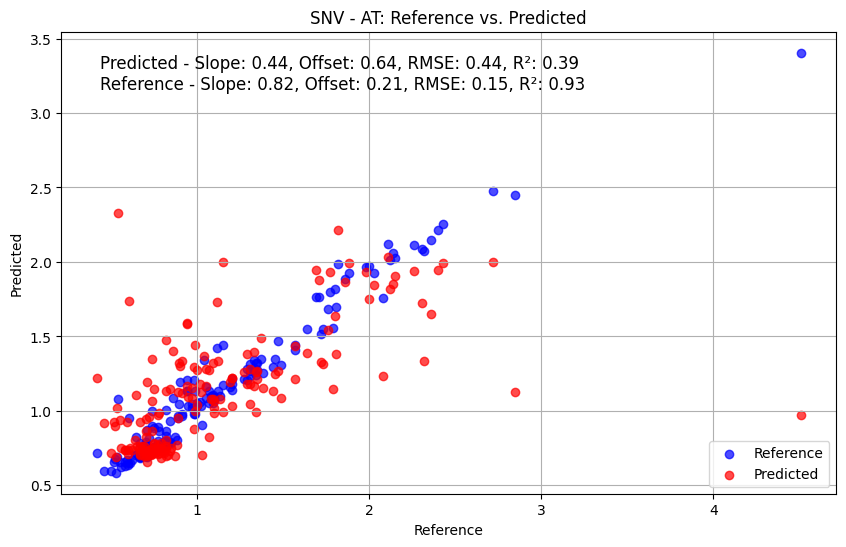

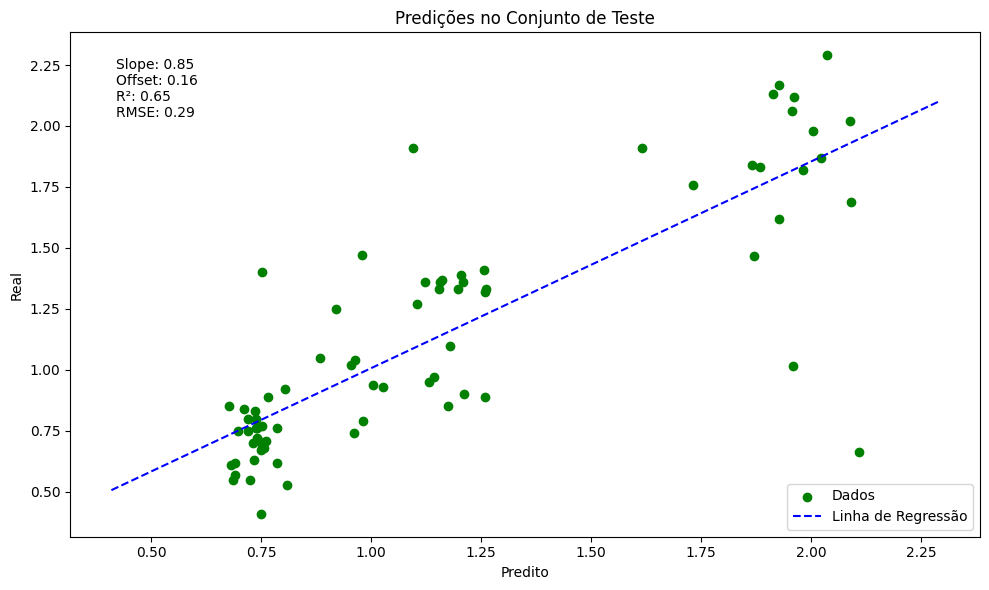

In [13]:
results_snv_at = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['AT'].values, df_snv_val.iloc[:, 6:], df_snv_val['AT'].values, 'SNV', 'AT')
infos_snv = add_plot_infos(infos_snv, results_snv_at, 'AT')

=== Training Metrics ===
R²: 0.9160
Correlation coefficient: 0.9730
RMSE: 0.0881
MAE: 0.0596
Relative absolute error: 25.1718
Root relative squared error: 28.9841
Slope: 1.2199
Offset: -0.7264
=== Cross-Validation Metrics ===
R²: 0.3114
Correlation coefficient: 0.5635
RMSE: 0.2524
MAE: 0.1604
Relative absolute error: 67.6993
Root relative squared error: 82.9846
Slope: 0.8964
Offset: 0.3291
=== Validation Metrics ===
R²: 0.4635
Correlation coefficient: 0.7024
RMSE: 0.2012
MAE: 0.1248
Relative absolute error: 51.2940
Root relative squared error: 73.2466
Slope: 1.0495
Offset: -0.1133


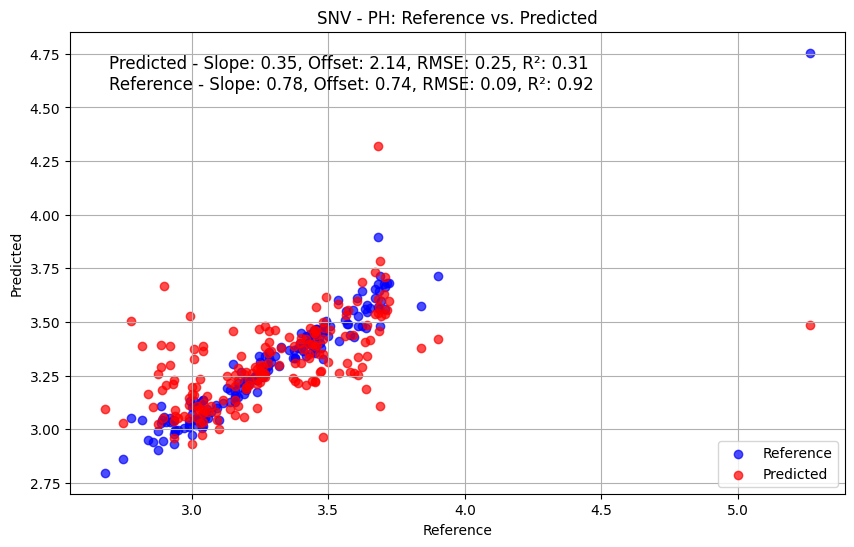

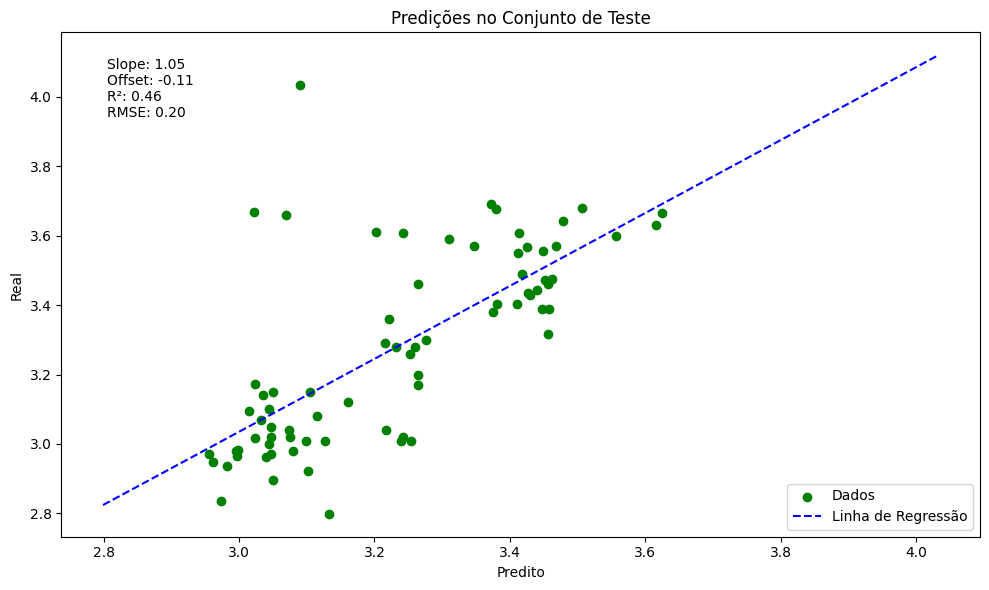

In [14]:
results_snv_ph = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['PH'].values, df_snv_val.iloc[:, 6:], df_snv_val['PH'].values, 'SNV', 'PH')
infos_snv = add_plot_infos(infos_snv, results_snv_ph, 'PH')

=== Training Metrics ===
R²: 0.9237
Correlation coefficient: 0.9703
RMSE: 26.3203
MAE: 21.1088
Relative absolute error: 28.2019
Root relative squared error: 27.6299
Slope: 1.1600
Offset: -82.0084
=== Cross-Validation Metrics ===
R²: 0.4476
Correlation coefficient: 0.6713
RMSE: 70.7991
MAE: 55.2226
Relative absolute error: 73.7791
Root relative squared error: 74.3216
Slope: 0.9244
Offset: 38.1233
=== Validation Metrics ===
R²: 0.5080
Correlation coefficient: 0.7319
RMSE: 68.2471
MAE: 56.2515
Relative absolute error: 67.7477
Root relative squared error: 70.1407
Slope: 0.9782
Offset: -4.7985


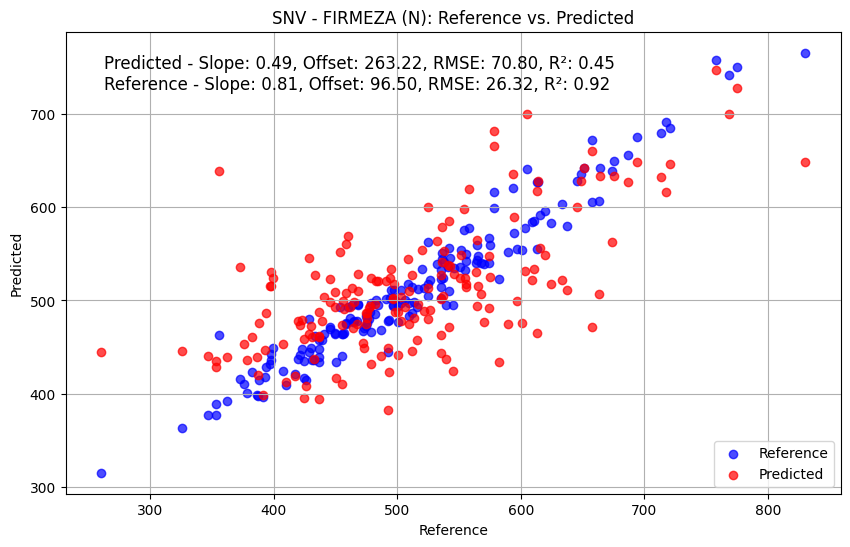

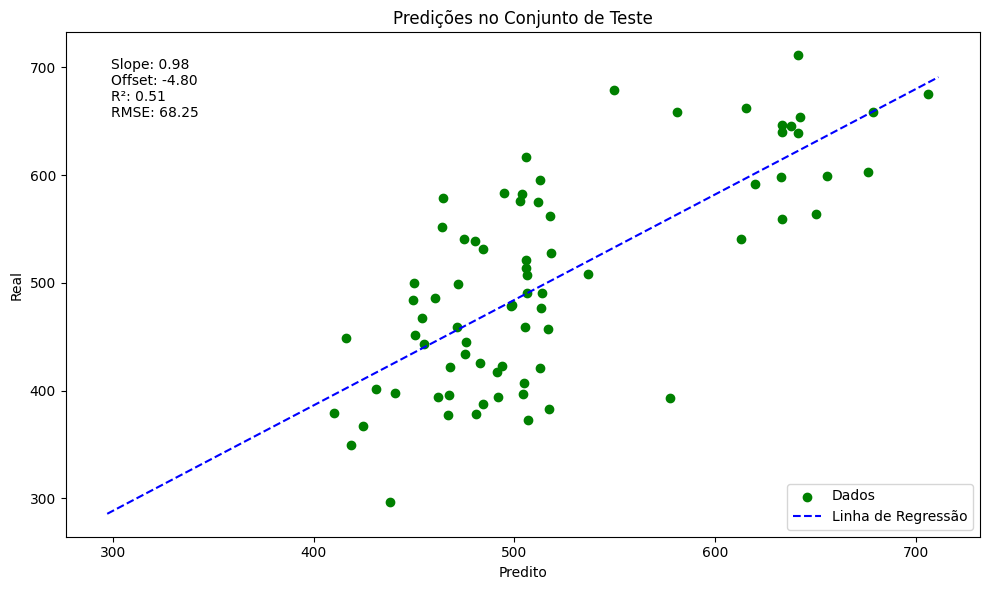

In [15]:
results_snv_firmeza = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['FIRMEZA (N)'].values, df_snv_val.iloc[:, 6:], df_snv_val['FIRMEZA (N)'].values, 'SNV', 'FIRMEZA (N)')
infos_snv = add_plot_infos(infos_snv, results_snv_firmeza, 'FIRMEZA (N)')

=== Training Metrics ===
R²: 0.9394
Correlation coefficient: 0.9766
RMSE: 0.7643
MAE: 0.4355
Relative absolute error: 18.9066
Root relative squared error: 24.6215
Slope: 1.1393
Offset: -2.1176
=== Cross-Validation Metrics ===
R²: 0.5949
Correlation coefficient: 0.7716
RMSE: 1.9758
MAE: 1.1782
Relative absolute error: 51.1487
Root relative squared error: 63.6474
Slope: 0.9992
Offset: 0.0750
=== Validation Metrics ===
R²: 0.7038
Correlation coefficient: 0.8536
RMSE: 1.3708
MAE: 0.9337
Relative absolute error: 42.7381
Root relative squared error: 54.4272
Slope: 0.8450
Offset: 2.3135


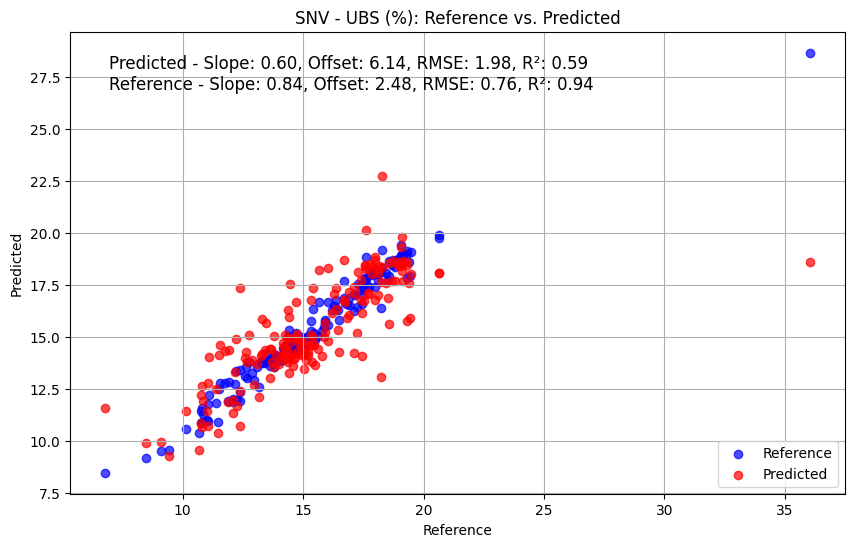

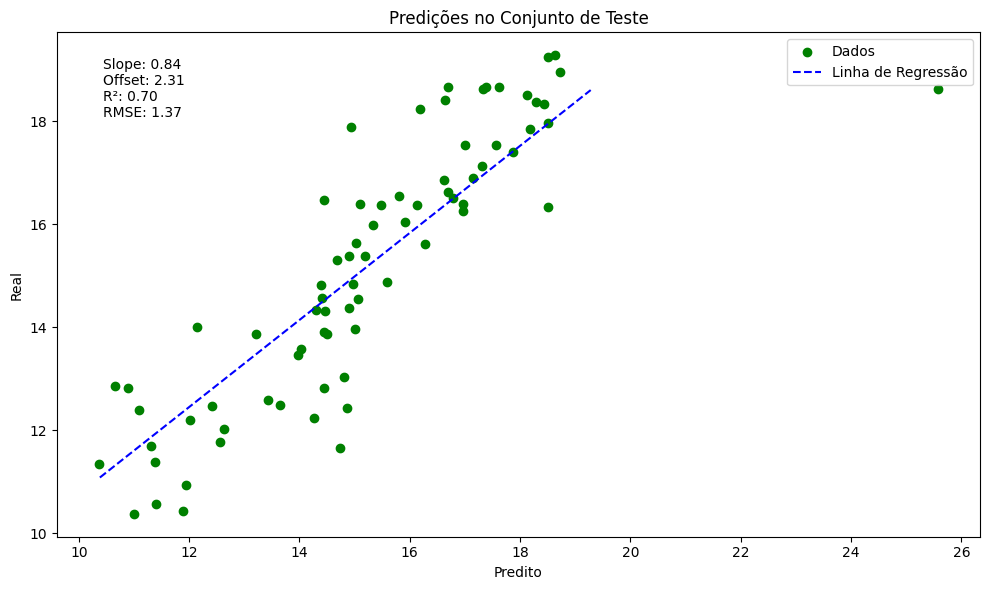

In [16]:
results_snv_ubs = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['UBS (%)'].values, df_snv_val.iloc[:, 6:], df_snv_val['UBS (%)'].values, 'SNV', 'UBS (%)')
infos_snv = add_plot_infos(infos_snv, results_snv_ubs, 'UBS (%)')

In [17]:
infos_snv.to_excel('plot_infos_RFR_snv.xlsx', index=False)
infos_snv

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.959763,0.982803,0.511559,0.416664,20.122218,20.059113,1.086243,-1.229718
1,SST,Cross-Validation,0.704181,0.839303,1.387067,1.125264,54.343063,54.389277,1.019015,-0.261733
2,SST,Validation,0.723637,0.851895,1.255449,0.993117,48.575514,52.570249,1.012079,-0.275449
3,AT,Training,0.930881,0.974618,0.148966,0.090034,21.496265,26.290443,1.163352,-0.191113
4,AT,Cross-Validation,0.391047,0.629658,0.442163,0.251168,59.968353,78.035428,0.904197,0.089749
5,AT,Validation,0.646508,0.818222,0.293640,0.192272,45.047306,59.455228,0.847424,0.159431
6,PH,Training,0.915992,0.973045,0.088147,0.059645,25.171777,28.984142,1.219928,-0.726447
7,PH,Cross-Validation,0.311355,0.563513,0.252374,0.160414,67.699320,82.984641,0.896356,0.329057
8,PH,Validation,0.463493,0.702415,0.201236,0.124819,51.294042,73.246617,1.049499,-0.113252
9,FIRMEZA (N),Training,0.923659,0.970349,26.320333,21.108767,28.201946,27.629879,1.160025,-82.008366


# SG - RFR

=== Training Metrics ===
R²: 0.9582
Correlation coefficient: 0.9858
RMSE: 0.5039
MAE: 0.4203
Relative absolute error: 20.8925
Root relative squared error: 20.4499
Slope: 1.1345
Offset: -1.8735
=== Cross-Validation Metrics ===
R²: 0.7055
Correlation coefficient: 0.8523
RMSE: 1.3374
MAE: 1.1060
Relative absolute error: 54.9815
Root relative squared error: 54.2712
Slope: 1.2040
Offset: -2.8059
=== Validation Metrics ===
R²: 0.7720
Correlation coefficient: 0.9022
RMSE: 1.2343
MAE: 0.9242
Relative absolute error: 42.4418
Root relative squared error: 47.7530
Slope: 1.2855
Offset: -3.8983


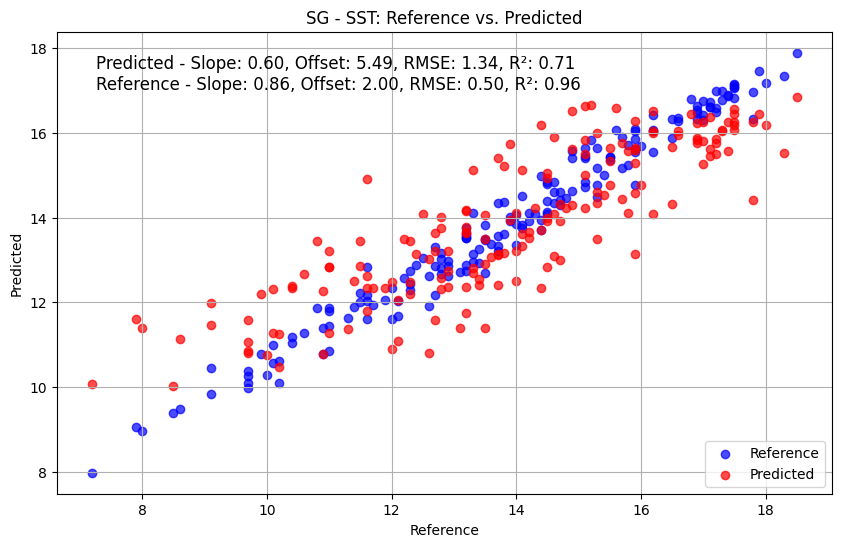

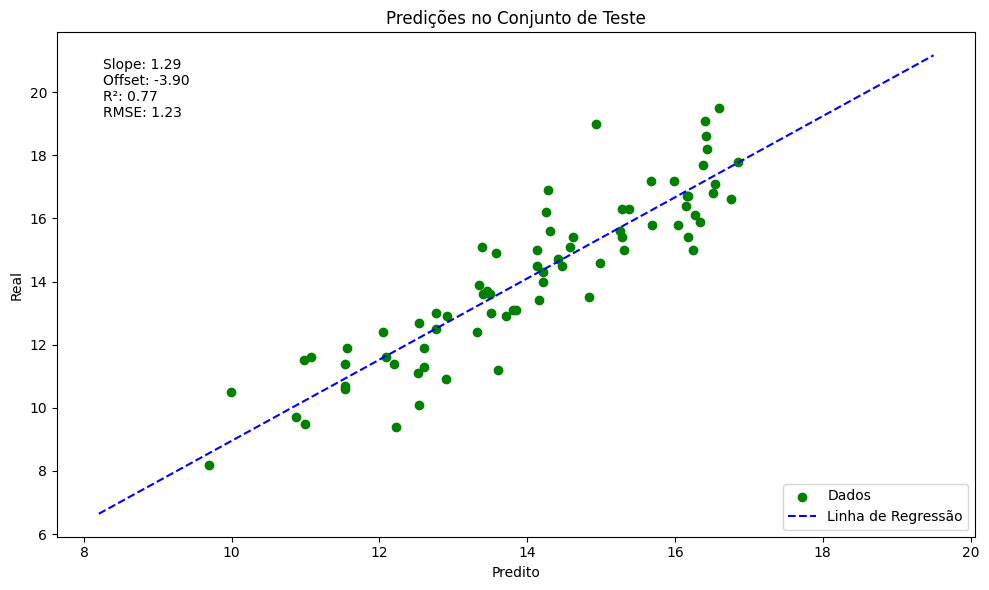

C:\Users\Luyza\AppData\Local\Temp\ipykernel_9400\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [18]:
results_sg_sst = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['SST'].values, df_sg_val.iloc[:, 6:], df_sg_val['SST'].values, 'SG', 'SST')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'SST')

=== Training Metrics ===
R²: 0.9462
Correlation coefficient: 0.9807
RMSE: 0.1223
MAE: 0.0841
Relative absolute error: 19.6827
Root relative squared error: 23.2022
Slope: 1.1462
Offset: -0.1678
=== Cross-Validation Metrics ===
R²: 0.6758
Correlation coefficient: 0.8298
RMSE: 0.3002
MAE: 0.2054
Relative absolute error: 48.0747
Root relative squared error: 56.9393
Slope: 1.1557
Offset: -0.1849
=== Validation Metrics ===
R²: 0.3220
Correlation coefficient: 0.5758
RMSE: 0.4840
MAE: 0.2226
Relative absolute error: 54.3804
Root relative squared error: 82.3434
Slope: 0.8595
Offset: 0.1408


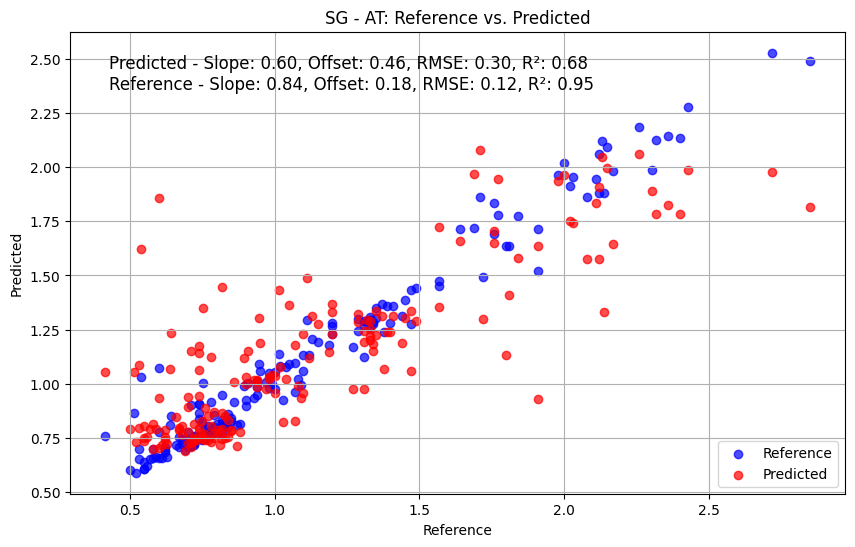

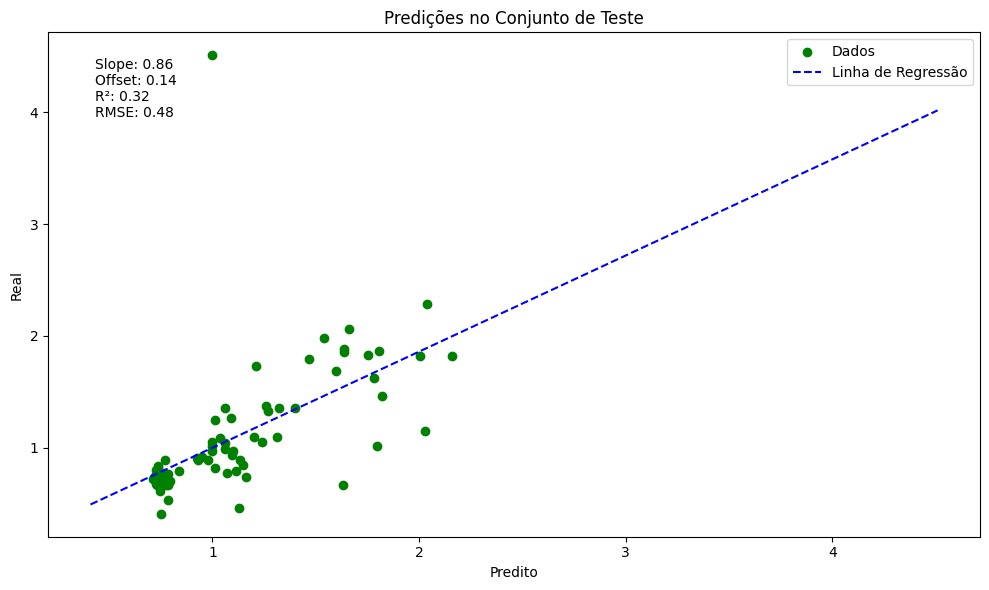

In [19]:
results_sg_at = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['AT'].values, df_sg_val.iloc[:, 6:], df_sg_val['AT'].values, 'SG', 'AT')
infos_sg = add_plot_infos(infos_sg, results_sg_at, 'AT')

=== Training Metrics ===
R²: 0.9171
Correlation coefficient: 0.9739
RMSE: 0.0877
MAE: 0.0548
Relative absolute error: 22.7930
Root relative squared error: 28.7910
Slope: 1.2221
Offset: -0.7353
=== Cross-Validation Metrics ===
R²: 0.4326
Correlation coefficient: 0.6585
RMSE: 0.2294
MAE: 0.1471
Relative absolute error: 61.1366
Root relative squared error: 75.3241
Slope: 1.0512
Offset: -0.1706
=== Validation Metrics ===
R²: 0.4758
Correlation coefficient: 0.6942
RMSE: 0.1899
MAE: 0.1147
Relative absolute error: 51.0127
Root relative squared error: 72.3986
Slope: 1.1000
Offset: -0.3352


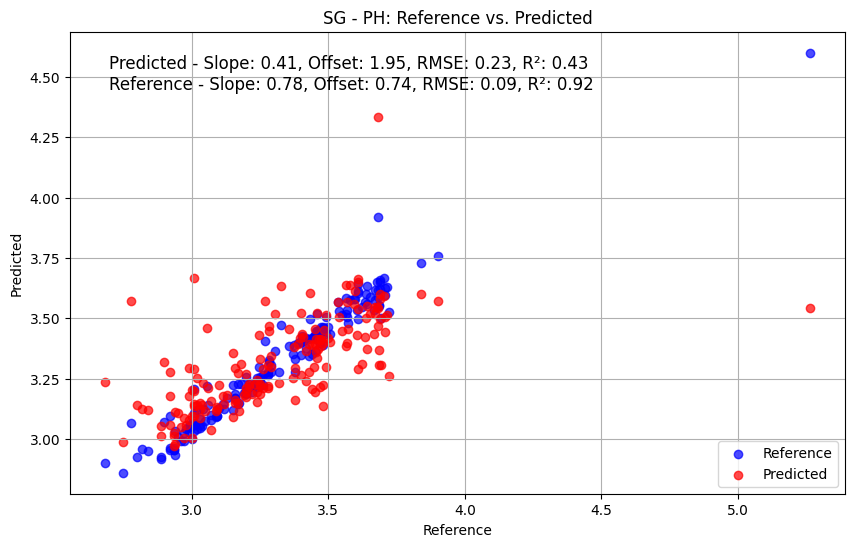

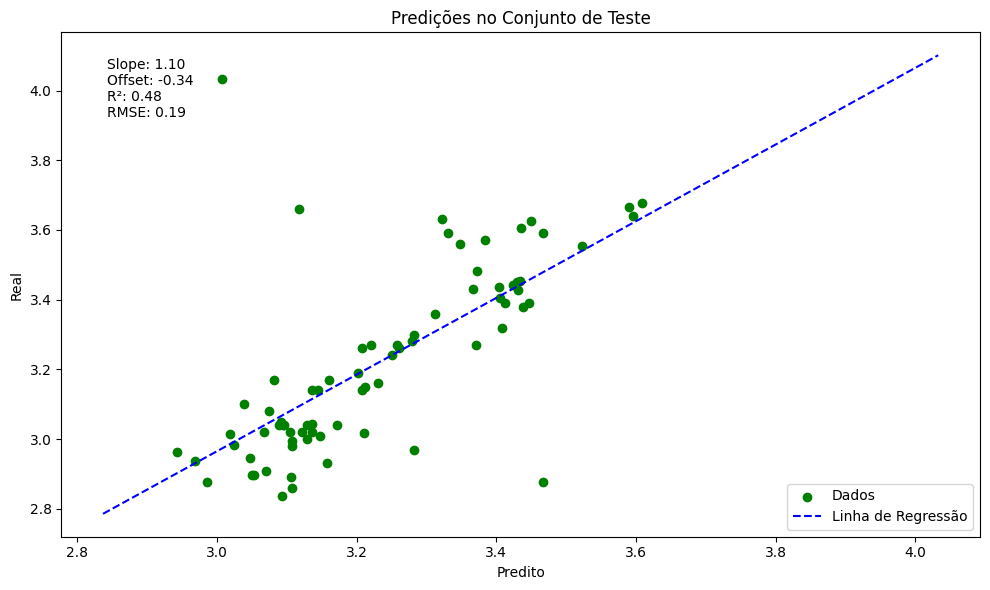

In [20]:
results_sg_ph = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['PH'].values, df_sg_val.iloc[:, 6:], df_sg_val['PH'].values, 'SG', 'PH')
infos_sg = add_plot_infos(infos_sg, results_sg_ph, 'PH')

=== Training Metrics ===
R²: 0.9257
Correlation coefficient: 0.9784
RMSE: 27.2071
MAE: 20.9565
Relative absolute error: 26.2685
Root relative squared error: 27.2634
Slope: 1.2214
Offset: -110.9697
=== Cross-Validation Metrics ===
R²: 0.4690
Correlation coefficient: 0.6904
RMSE: 72.7218
MAE: 56.6124
Relative absolute error: 70.9625
Root relative squared error: 72.8723
Slope: 1.1432
Offset: -71.0944
=== Validation Metrics ===
R²: 0.3318
Correlation coefficient: 0.6124
RMSE: 70.1573
MAE: 56.1510
Relative absolute error: 78.2528
Root relative squared error: 81.7417
Slope: 0.8524
Offset: 89.4893


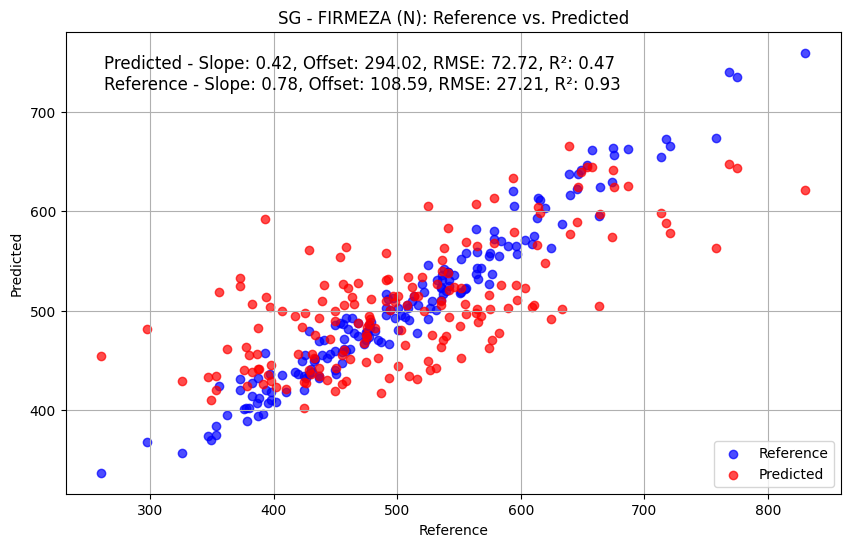

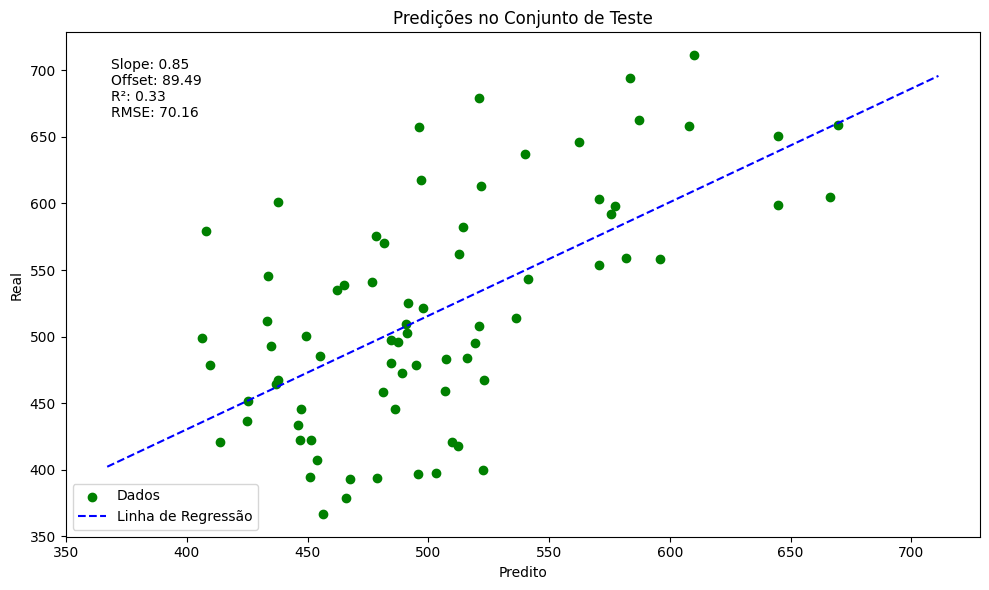

In [21]:
results_sg_firmeza = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['FIRMEZA (N)'].values, df_sg_val.iloc[:, 6:], df_sg_val['FIRMEZA (N)'].values, 'SG', 'FIRMEZA (N)')
infos_sg = add_plot_infos(infos_sg, results_sg_firmeza, 'FIRMEZA (N)')

=== Training Metrics ===
R²: 0.9466
Correlation coefficient: 0.9831
RMSE: 0.7101
MAE: 0.4306
Relative absolute error: 18.8324
Root relative squared error: 23.0994
Slope: 1.1671
Offset: -2.5301
=== Cross-Validation Metrics ===
R²: 0.5960
Correlation coefficient: 0.7784
RMSE: 1.9539
MAE: 1.1116
Relative absolute error: 48.6115
Root relative squared error: 63.5644
Slope: 1.1459
Offset: -2.1837
=== Validation Metrics ===
R²: 0.8384
Correlation coefficient: 0.9218
RMSE: 1.0487
MAE: 0.7909
Relative absolute error: 35.8156
Root relative squared error: 40.1952
Slope: 1.1287
Offset: -1.9194


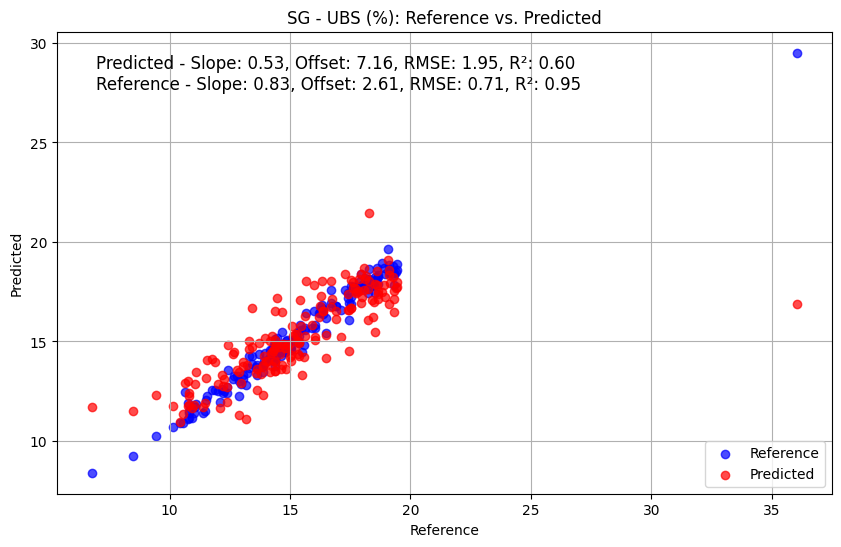

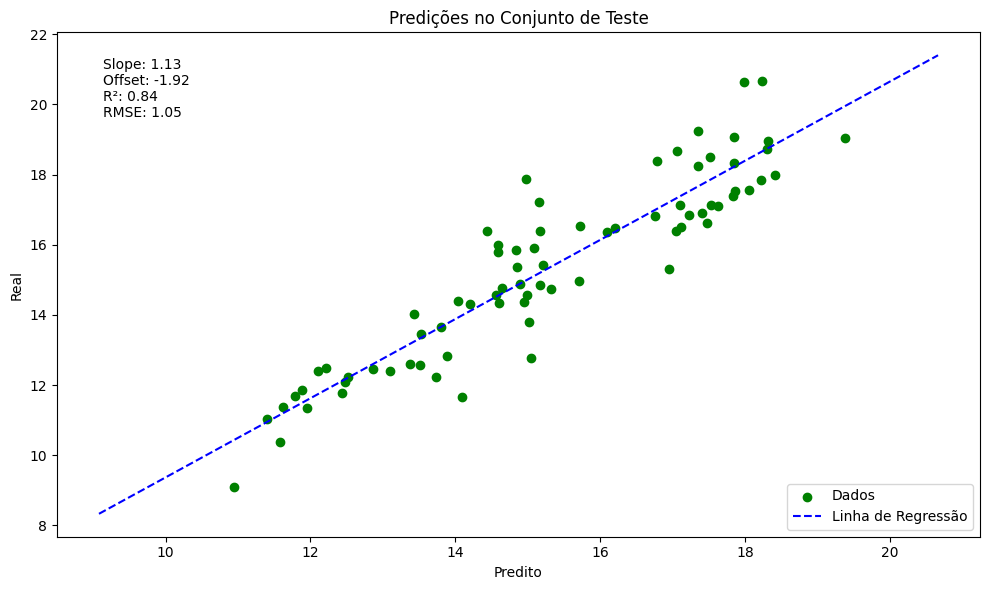

In [22]:
results_sg_ubs = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['UBS (%)'].values, df_sg_val.iloc[:, 6:], df_sg_val['UBS (%)'].values, 'SG', 'UBS (%)')
infos_sg = add_plot_infos(infos_sg, results_sg_ubs, 'UBS (%)')

In [23]:
infos_sg.to_excel('plot_infos_RFR_sg.xlsx', index=False)
infos_sg

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.958180,0.985821,0.503946,0.420264,20.892464,20.449917,1.134519,-1.873533
1,SST,Cross-Validation,0.705464,0.852308,1.337400,1.105986,54.981515,54.271190,1.203952,-2.805871
2,SST,Validation,0.771965,0.902230,1.234304,0.924167,42.441768,47.753049,1.285488,-3.898273
3,AT,Training,0.946166,0.980744,0.122311,0.084104,19.682676,23.202192,1.146219,-0.167825
4,AT,Cross-Validation,0.675791,0.829799,0.300158,0.205423,48.074666,56.939315,1.155654,-0.184854
5,AT,Validation,0.321957,0.575809,0.483950,0.222579,54.380424,82.343355,0.859546,0.140775
6,PH,Training,0.917108,0.973881,0.087674,0.054849,22.792997,28.791049,1.222118,-0.735317
7,PH,Cross-Validation,0.432628,0.658531,0.229376,0.147119,61.136559,75.324126,1.051240,-0.170624
8,PH,Validation,0.475845,0.694176,0.189864,0.114667,51.012728,72.398571,1.100029,-0.335182
9,FIRMEZA (N),Training,0.925671,0.978376,27.207090,20.956470,26.268497,27.263415,1.221432,-110.969667


# Teste

In [4]:
X_test, y_test = df_msc_val.iloc[:,6:], df_msc_val['SST'].values
X_train, y_train = df_msc_cal.iloc[:,6:], df_msc_cal['SST'].values

In [8]:
# Definir o pipeline
pipeline = make_pipeline(
    StandardScaler(),  # Normalização dos dados
    RandomForestRegressor(
        random_state=1  # Semente aleatória para reprodutibilidade
    )
)

# Definir os parâmetros para o GridSearch
param_grid = {
    'randomforestregressor__n_estimators': [50, 80],  # Número de árvores
    'randomforestregressor__max_features': ['sqrt', 'log2'],  # Número de características consideradas para cada divisão
    'randomforestregressor__max_depth': [20, 30, 40],  # Profundidade máxima da árvore
    'randomforestregressor__min_samples_split': [2, 5],  # Número mínimo de amostras necessárias para dividir um nó
    'randomforestregressor__min_samples_leaf': [1, 2],  # Número mínimo de amostras necessárias em um nó folha
    'randomforestregressor__bootstrap': [True, False],  # Amostragem bootstrap
}

# Definir o GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Usando MAE como métrica de avaliação
    cv=175,  # Validação cruzada com 5 folds
    n_jobs=-1,  # Utiliza todos os processadores disponíveis
    verbose=3  # Mostra detalhes do processo
)

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Resultados do GridSearch
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Fazer previsões no conjunto de teste usando o melhor modelo encontrado
y_pred = grid_search.predict(X_test)

# Calcular e exibir as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nResultados no conjunto de teste:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")


Fitting 175 folds for each of 96 candidates, totalling 16800 fits


Melhores parâmetros encontrados:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 80}

Resultados no conjunto de teste:
MAE (Mean Absolute Error): 0.9844
RMSE (Root Mean Squared Error): 1.1926
R² (Coeficiente de Determinação): 0.6788


In [3]:
def testrfr(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "Correlation coefficient": correlation_coefficient,
            "Mean absolute error": mae,
            "Root mean squared error": rmse,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Total Number of Instances": len(y_true)
        }

    def display_metrics(title, metrics):
        print(f"\n=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        RandomForestRegressor(
            n_estimators=50,  # Número de árvores
            max_features='sqrt', # Usar raiz quadrada do número de características
            max_depth=20,    # Profundidade das árvores
            min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó
            min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
            bootstrap=True,    # Usar amostragem bootstrap
            oob_score=False,   # Não usar amostragem fora da bolsa
            random_state=1     # Semente aleatória
        )
    )

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results = []

    for metric, value in training_metrics.items():
        results.append({'Métrica': f'Training {metric}', 'Valor': value})
    
    for metric, value in cv_metrics.items():
        results.append({'Métrica': f'CV {metric}', 'Valor': value})
    
    for metric, value in validation_metrics.items():
        results.append({'Métrica': f'Validation {metric}', 'Valor': value})

    # Converter os resultados para um DataFrame
    results_df = pd.DataFrame(results)
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title("Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df
